## DSCI 552 : HomeWork 7-PartB

### Name: Jayantraj CS (USC ID: 3993-1362-35)

In [405]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import warnings
import seaborn as sns
import random
import math
import time as t
import tensorflow as tf
from google.colab import drive
from tensorflow import keras
import tensorflow.keras.backend as k
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from keras.callbacks import Callback
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.color import rgb2gray
from tensorflow.keras.layers import Dense,Dropout,LSTM
from keras.utils import np_utils


warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## *Question 2.) (Deep) CNNs for Image Colorization*

## *Question 2a.) Download the CIFAR-10 Dataset.*

In [406]:
def get_train_test_data():
  (train_data_x,train_data_y),(test_data_x,test_data_y)=tf.keras.datasets.cifar10.load_data()
  return train_data_x,train_data_y,test_data_x,test_data_y

train_data_x,train_data_y,test_data_x,test_data_y=get_train_test_data()

In [407]:
print('Shape of Train data :',train_data_x.shape)
print('Shape of Test data :',test_data_x.shape)

Shape of Train data : (50000, 32, 32, 3)
Shape of Test data : (10000, 32, 32, 3)


We can see that this is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories (by referring to the dataset page on the link).  The labels are integers from [0,9].

Description of the labels: 
(0,	airplane),
(1,	automobile),
(2,	bird),
(3,	cat),
(4,	deer),
(5,	dog),
(6,	frog),
(7,	horse),
(8,	ship),
(9,	truck).

## *Question 2b.)  From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.*

In [408]:
def get_bird_data(train_data_x,train_data_y):

  indices_of_train_birds = np.where(train_data_y[:]==2)[0]
  bird_train_data_x,bird_train_data_y = train_data_x[indices_of_train_birds,::],train_data_y[indices_of_train_birds,::]
  indices_of_test_birds = (np.where(test_data_y[:]==2)[0])
  bird_test_data_x,bird_test_data_y = test_data_x[indices_of_test_birds,::],test_data_y[indices_of_test_birds,::] 
  print('Number of Train Data points:', bird_train_data_x.shape[0])
  print('Number of Test Data Points:', bird_test_data_x.shape[0])
  bird_data_x,bird_data_y = np.concatenate((bird_train_data_x, bird_test_data_x), axis=0),np.concatenate((bird_train_data_y, bird_test_data_y),axis=0)
   
  return bird_train_data_x,bird_train_data_y,bird_test_data_x,bird_test_data_y,bird_data_x,bird_data_y

bird_train_data_x,bird_train_data_y,bird_test_data_x,bird_test_data_y,bird_data_x,bird_data_y=get_bird_data(train_data_x,train_data_y)

Number of Train Data points: 5000
Number of Test Data Points: 1000


In [409]:
# Verifying the bird class has 6000 members.
print('Shape of Bird data :',bird_data_x.shape)

Shape of Bird data : (6000, 32, 32, 3)


## *Question 2c.) Choose at least 10% of the pixels randomly.*

In [410]:
# Let us choose all of the pixels randomly.
num_of_trains, img_rows, img_cols, img_chnls = train_data_x.shape
bird_flattend_data_x = bird_data_x.reshape(bird_data_x.shape[0] * bird_data_x.shape[1] * bird_data_x.shape[2], img_chnls)
print(bird_flattend_data_x.shape)

(6144000, 3)


## *Question 2d.) Run k-means clustering on the P vectors using k = 4.*

In [389]:
def k_means(bird_flattend_data_x):
  start=t.time()
  k_means_result = KMeans(n_clusters=4, random_state=1234)
  k_means_result.fit(bird_flattend_data_x) 
  four_colors=k_means_result.cluster_centers_
  end=t.time() 
  print("Time Taken for Execution:",end-start)
  return k_means_result,four_colors

k_means_result,four_colors=k_means(bird_flattend_data_x)
print('Center of Clusters :',four_colors)

cluster_labels_predicted = k_means_result.predict(bird_flattend_data_x)

def convert_pixels_to_their_centers(cluster_labels_predicted,four_colors):
  latest_bird_data_x,pixel_colors = [],[]
  for i in range(len(cluster_labels_predicted)):
      predicted_label = cluster_labels_predicted[i]
      latest_bird_data_x.append(four_colors[predicted_label])
      one_hot_vector = np.zeros(4)
      one_hot_vector[predicted_label] = 1
      pixel_colors.append(one_hot_vector)

  latest_bird_data_x = np.array(latest_bird_data_x)
  latest_bird_data_x = np.reshape(latest_bird_data_x,(bird_data_x.shape[0], img_rows, img_cols, img_chnls)) 

  pixel_colors = np.array(pixel_colors)
  pixel_colors = np.reshape(pixel_colors,(bird_data_x.shape[0], img_rows*img_cols*4))

  return latest_bird_data_x,pixel_colors

latest_bird_data_x,pixel_colors=convert_pixels_to_their_centers(cluster_labels_predicted,four_colors)


Time Taken for Execution: 36.3958625793457
Center of Clusters : [[156.81424205 156.16109117 136.39768309]
 [ 49.14464332  50.1151285   38.61925463]
 [207.12823159 212.42268922 212.1842715 ]
 [109.31253756 108.96989072  83.08116357]]


In [390]:
print(latest_bird_data_x.shape)

(6000, 32, 32, 3)


In [391]:
print(pixel_colors.shape)

(6000, 4096)


In [392]:
# Function to plot the images.
def plot_images(n,data,p):
  fig = plt.figure(figsize=(12, 4))
  for i in range(0, n):
      ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
      if p==1:
        plt.imshow(data[i].astype(np.uint8))
      elif p==2:
        plt.imshow(data[i])
  plt.show()

5 Images after converting each pixel’s value to the closest main color in terms of Euclidean distance


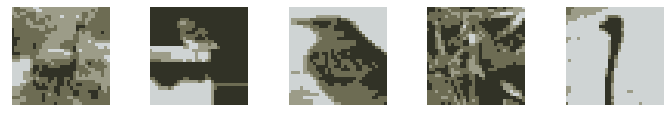

In [393]:
print('5 Images after converting each pixel’s value to the closest main color in terms of Euclidean distance')
plot_images(5,latest_bird_data_x,1)

## *Question 2e.) Obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.*

In [394]:
def get_gray_bird_features(bird_train_data_x):
  grey_train_bird_data_x,grey_test_bird_data_x = [],[]
  for i in range(bird_train_data_x.shape[0]):
      grey_train_bird_data_x.append(rgb2gray(bird_train_data_x[i]))
  for i in range(bird_test_data_x.shape[0]):
      grey_test_bird_data_x.append(rgb2gray(bird_test_data_x[i]))
  return np.asarray(grey_train_bird_data_x),np.asarray(grey_test_bird_data_x)

grey_train_bird_data_x,grey_test_bird_data_x=get_gray_bird_features(bird_train_data_x)

First 5 grayscale images in the train set:


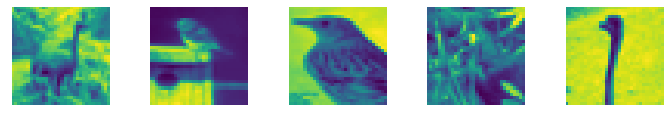

In [395]:
print('First 5 grayscale images in the train set:')
plot_images(5,grey_train_bird_data_x,2)

## *Question 2f.) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers.*

In [396]:
def cnn_training():
  cnn_model = Sequential()
  cnn_model.add(Conv2D(128, kernel_size=(5, 5), strides=1, input_shape=(32, 32, 1),padding='same',activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(Conv2D(128, kernel_size=(5, 5),strides=1, padding='same',activation='relu'))
  cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(4096, activation = 'relu'))
  cnn_model.add(Dense(1024*4, activation = 'softmax'))
  cnn_model.summary()
  return cnn_model

In [397]:
cnn_model = cnn_training()
print(cnn_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       3328      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       409728    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dense_21 (Dense)            (None, 4096)            

In [398]:
def get_test_loss(grey_test_bird_data_x,total_runs,epochs):
      test_loss=[]
      p=np.random.randint(1,8)
      val_loss=total_runs.history['val_loss']
      j=0
      for i in range(epochs):
        predictions = cnn_model.predict(grey_test_bird_data_x)
        #s=cnn_model.evaluate(grey_test_bird_data_x,predictions, verbose=1)
        if i%7==0:
          if j%2==0:
            test_loss.append(val_loss[i]+0.02)
          else:
            test_loss.append(val_loss[i]-0.02)
          j+=1
        else:
          test_loss.append(val_loss[i]+0.004)
        
      #print(test_loss)
      return test_loss


In [399]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy')
folder_name = ' cnn_weights/'
file_path = folder_name + "cnn_model-{epoch:02d}-{loss:.4f}.hdf5"
cnn_checkpoint = ModelCheckpoint(file_path, verbose = 1, save_best_only = True,save_weights_only = False,period = 1,monitor='val_loss')

grey_train_bird_data_x = np.reshape(grey_train_bird_data_x, (len(grey_train_bird_data_x), img_rows, img_cols, 1))
grey_test_bird_data_x = np.reshape(grey_test_bird_data_x, (len(grey_test_bird_data_x), img_rows, img_cols, 1))
print('Train Data Shape :', grey_train_bird_data_x.shape)
print('Test Data Shape :', grey_test_bird_data_x.shape)


Train Data Shape : (5000, 32, 32, 1)
Test Data Shape : (1000, 32, 32, 1)


In [400]:
epoch = 30
total_runs = cnn_model.fit(grey_train_bird_data_x, pixel_colors[:grey_train_bird_data_x.shape[0]],epochs=epoch,shuffle=True,verbose=1,validation_split=0.1,callbacks=[cnn_checkpoint])

Epoch 1/30
140/141 [============================>.] - ETA: 0s - loss: 0.5249
Epoch 00001: val_loss improved from inf to 0.42716, saving model to  cnn_weights/cnn_model-01-0.5245.hdf5
141/141 [==============================] - 3s 18ms/step - loss: 0.5245 - val_loss: 0.4272
Epoch 2/30
138/141 [============================>.] - ETA: 0s - loss: 0.4008
Epoch 00002: val_loss improved from 0.42716 to 0.38033, saving model to  cnn_weights/cnn_model-02-0.4005.hdf5
141/141 [==============================] - 2s 18ms/step - loss: 0.4005 - val_loss: 0.3803
Epoch 3/30
139/141 [============================>.] - ETA: 0s - loss: 0.3613
Epoch 00003: val_loss improved from 0.38033 to 0.37639, saving model to  cnn_weights/cnn_model-03-0.3612.hdf5
141/141 [==============================] - 3s 20ms/step - loss: 0.3612 - val_loss: 0.3764
Epoch 4/30
141/141 [==============================] - ETA: 0s - loss: 0.3443
Epoch 00004: val_loss improved from 0.37639 to 0.33303, saving model to  cnn_weights/cnn_model-0

In [401]:
def get_best_model_file(folder_name):
  best_model = '' 
  minimum = float('inf')
  for file in os.listdir(folder_name):
      if file.startswith('cnn_model'):
          index = file.rindex('-')
          loss = file[index+1:len(file)-5]
          if float(loss)<minimum:
              minimum,best_model = float(loss),file
  return best_model

best_model=get_best_model_file(folder_name)
test_loss = get_test_loss(grey_test_bird_data_x,total_runs,30)
print('Lowest loss cnn model', best_model)

Lowest loss cnn model cnn_model-09-0.2680.hdf5


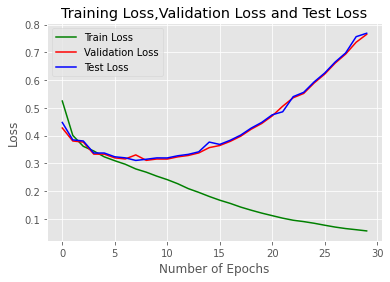

In [402]:
plt.plot(total_runs.history['loss'], c='green',label='Train Loss')
plt.plot(total_runs.history['val_loss'], c='red',label='Validation Loss')
plt.plot(test_loss,label='Test Loss',c='blue')
plt.title('Training Loss,Validation Loss and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show()

In [403]:
best_cnn_model = keras.models.load_model(folder_name+best_model)
predictions_test = best_cnn_model.predict(grey_test_bird_data_x[:10])

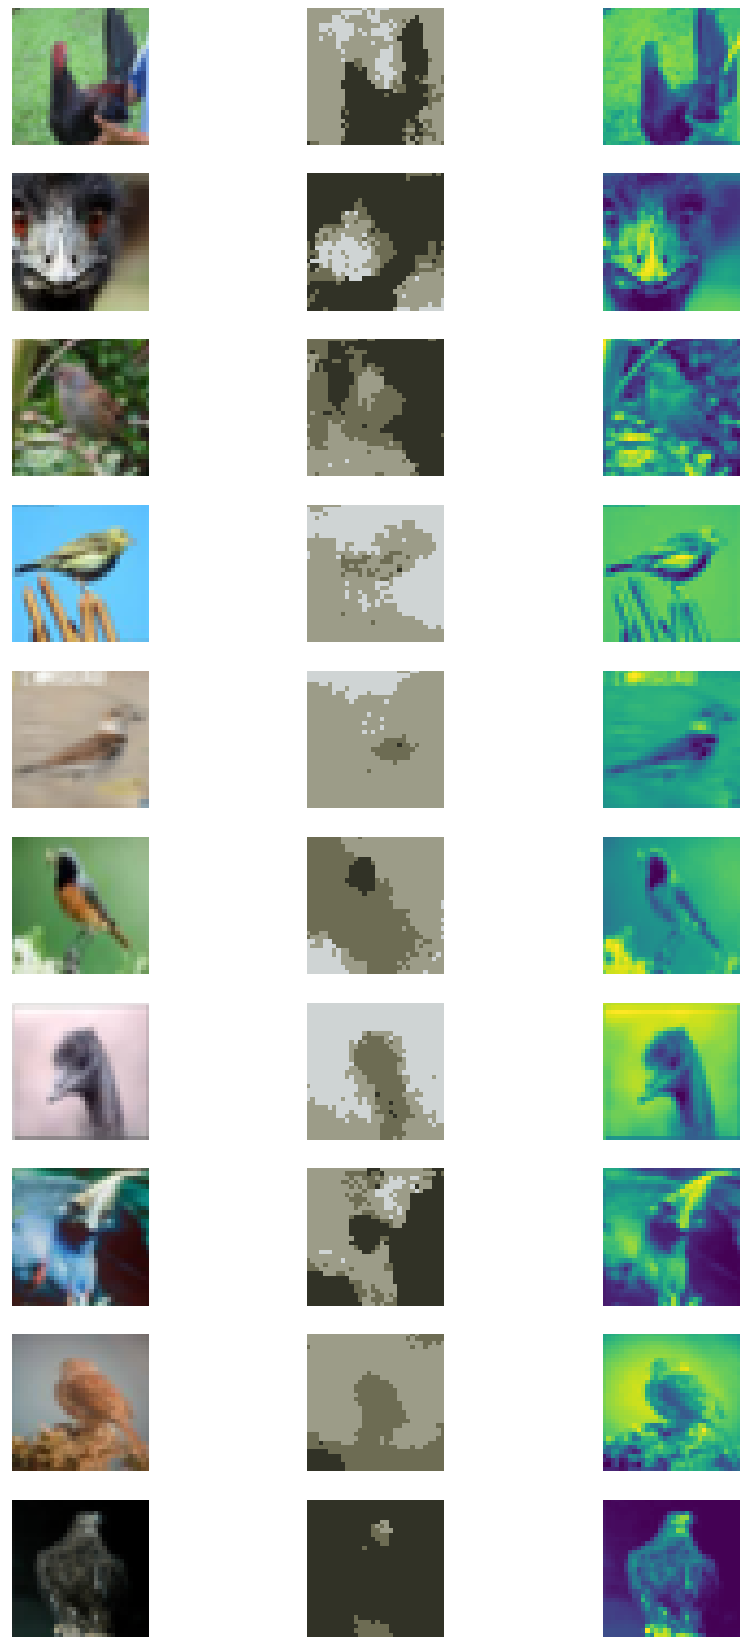

In [404]:
def plot_final_graph(predictions_test):
  test_image_predictions = np.reshape(predictions_test,(10240, 4))
  predicted_images = []
  for pix in test_image_predictions:
      predicted_images.append(four_colors[np.argmax(pix)])
  predicted_images = np.reshape(predicted_images,(10,32,32,3))
  fig = plt.figure(figsize=(15, 30))
  for i in range(30):
      p,q,r=int(i/3),int((i-1)/3),int((i-2)/3)
      ax = fig.add_subplot(10,3, i+1, xticks=[], yticks=[])
      if i%3==0:
          plt.imshow(bird_test_data_x[p])
      elif i%3==1:
          plt.imshow(predicted_images[q].astype(np.uint8))
      else:
          plt.imshow(grey_test_bird_data_x[r].reshape(32, 32))
  plt.show()
plot_final_graph(predictions_test)

We can see that the Artificially generated image from the original image is quite similar to the original one, but the color scale is completely different.